In [ ]:
import torch
import numpy as np
from einops import einsum

from diffusers import DiffusionPipeline
from evotorch import Problem
from evotorch.decorators import vectorized
from evotorch.algorithms import CMAES, SNES, CEM
from evotorch.logging import StdOutLogger, PandasLogger
from noise_injection_pipelines.sampling_pipelines import (
    SDXLSamplingPipeline,
    SD3SamplingPipeline,
)
from fitness.fitness_fn import (
    brightness,
    clip_fitness_fn,
    compose_fitness_fns,
    relative_luminance,
    Novelty,
    pickscore_fitness_fn,
    aesthetic_fitness_fn,
    imagereward_fitness_fn,
)
from evo.vectorized_problem import VectorizedProblem
from diffusers.utils import pt_to_pil, numpy_to_pil
import matplotlib.pyplot as plt

from noise_injection_pipelines.noise_injection import (
    rotational_transform,
    noise
)
from noise_injection_pipelines.initialization import randn_intialization, rotation_initalization
from functools import partial

In [ ]:
model_name = "stabilityai/sdxl-turbo"
model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = DiffusionPipeline.from_pretrained(
    model_name, torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
)
# pipe.enable_xformers_memory_efficient_attention()
# pipe.enable_model_cpu_offload()

In [ ]:
problem_split = 6
num_inference_steps = 15
noise_scale = 1.0
prompt = "A beautiful landscape painting"
sample_fn = SDXLSamplingPipeline(
    pipe,
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator().manual_seed(0),
    guidance_scale=5.0
)

# image_rew = imagereward_fitness_fn([prompt], device=pipe.device, dtype=pipe.dtype)
fit = compose_fitness_fns([brightness], [1])

In [ ]:
mean_scale = 0.01
initial_bounds = (-0.1, 0.1)
injection_steps = num_inference_steps
sample_fn.inject_multiple_noise_scale = noise_scale

fitness_fn, inner_fn, centroid, solution_length = rotational_transform(
    sample_fn,
    fit,
    sample_fn.latents.shape,
    center=sample_fn.latents,
    dtype=pipe.dtype,
)

problem = VectorizedProblem(
    "max",
    fitness_fn,
    solution_length=solution_length,
    initial_bounds=initial_bounds,
    dtype=np.dtype("float32"),
    splits=problem_split,
    # initialization=None,
    initialization=partial(rotation_initalization, solution_length=solution_length, latents_shape=sample_fn.latents.shape, stdev=0.1),
)
# searcher = CMAES(problem, stdev_init=1, separable=True, csa_squared=True)
searcher = SNES(problem, stdev_init=5)
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)
# print(f"pop. size: {searcher.popsize}")

In [ ]:
a = sample_fn()
plt.imshow(numpy_to_pil(a)[0])
plt.show()
print(fit(a[0]))
with torch.no_grad():
    for step in range(200):
        searcher.step()
        best_idx = searcher.population.argbest()
        x = searcher.population[best_idx].values

        a = inner_fn(x)
        plt.imshow(numpy_to_pil(a)[0])
        plt.show()

## SDXL Quantized

In [ ]:
from diffusers import BitsAndBytesConfig as DiffusersBitsAndBytesConfig
from diffusers import UNet2DConditionModel

In [ ]:
model_name = "stabilityai/sdxl-turbo"

quant_config = DiffusersBitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16
)

unet = UNet2DConditionModel.from_pretrained(
    model_name,
    subfolder="unet",
    quantization_config=quant_config,
    torch_dtype=torch.float16,
)

pipe = DiffusionPipeline.from_pretrained(
    model_name, torch_dtype=torch.float16, use_safetensors=True, unet=unet
)
# pipe.enable_xformers_memory_efficient_attention()
# pipe.enable_model_cpu_offload()

In [ ]:
problem_split = 6
num_inference_steps = 15
noise_scale = 1.0
prompt = "A small domesticated carnivorous mammal with soft fur, a short snout, and retractable claws. It is widely kept as a pet or for catching mice, and many breeds have been developed."
sample_fn = SDXLSamplingPipeline(
    pipe,
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator(device=pipe.device).manual_seed(0),
    guidance_scale=5.0
)

image_rew = imagereward_fitness_fn([prompt], device=pipe.device, dtype=pipe.dtype)
fit = compose_fitness_fns([image_rew], [1])

In [ ]:
mean_scale = 0.01
initial_bounds = (-0.1, 0.1)
injection_steps = num_inference_steps
sample_fn.inject_multiple_noise_scale = noise_scale

fitness_fn, inner_fn, centroid, solution_length = rotational_transform(
    sample_fn,
    fit,
    sample_fn.latents.shape,
    device=pipe.device,
    center=sample_fn.latents,
    dtype=pipe.dtype,
)

problem = VectorizedProblem(
    "max",
    fitness_fn,
    solution_length=solution_length,
    initial_bounds=initial_bounds,
    dtype=np.dtype("float32"),
    splits=problem_split,
    # initialization=None,
    initialization=partial(rotation_initalization, solution_length=solution_length, latents_shape=sample_fn.latents.shape, stdev=0.0),
)
# searcher = CMAES(problem, stdev_init=1, separable=True, csa_squared=True)
searcher = SNES(problem, stdev_init=0.1)
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)
# print(f"pop. size: {searcher.popsize}")

In [ ]:
a = sample_fn()
plt.imshow(numpy_to_pil(a)[0])
plt.show()
print(fit(a[0]))
with torch.no_grad():
    for step in range(200):
        searcher.step()
        best_idx = searcher.population.argbest()
        x = searcher.population[best_idx].values

        a = inner_fn(x)
        plt.imshow(numpy_to_pil(a)[0])
        plt.show()

# SD3

In [ ]:
from diffusers import BitsAndBytesConfig, SD3Transformer2DModel
from diffusers import StableDiffusion3Pipeline
import torch

# model_id = "stabilityai/stable-diffusion-3.5-medium"
model_id = "tensorart/stable-diffusion-3.5-medium-turbo"

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
model_nf4 = SD3Transformer2DModel.from_pretrained(
    model_id,
    subfolder="transformer",
    quantization_config=nf4_config,
    torch_dtype=torch.float16
)

pipeline = StableDiffusion3Pipeline.from_pretrained(
    model_id, 
    transformer=model_nf4,
    torch_dtype=torch.float16
)


pipeline.enable_xformers_memory_efficient_attention()
pipeline.enable_model_cpu_offload()

In [ ]:
prompt = "A whimsical and creative image depicting a hybrid creature that is a mix of a waffle and a hippopotamus, basking in a river of melted butter amidst a breakfast-themed landscape. It features the distinctive, bulky body shape of a hippo. However, instead of the usual grey skin, the creature's body resembles a golden-brown, crispy waffle fresh off the griddle. The skin is textured with the familiar grid pattern of a waffle, each square filled with a glistening sheen of syrup. The environment combines the natural habitat of a hippo with elements of a breakfast table setting, a river of warm, melted butter, with oversized utensils or plates peeking out from the lush, pancake-like foliage in the background, a towering pepper mill standing in for a tree.  As the sun rises in this fantastical world, it casts a warm, buttery glow over the scene. The creature, content in its butter river, lets out a yawn. Nearby, a flock of birds take flight"
prompt = "A small domesticated carnivorous mammal with soft fur, a short snout, and retractable claws. It is widely kept as a pet or for catching mice, and many breeds have been developed."

sample_fn = SD3SamplingPipeline(
    pipeline,
    prompt=prompt,
    num_inference_steps=15,
    generator=torch.Generator(device=pipeline.device).manual_seed(1),
    guidance_scale=4.5,
    add_noise=False
)

In [ ]:
image_rew = imagereward_fitness_fn(
    [prompt], device=pipeline.device, dtype=pipeline.dtype
)
fit = compose_fitness_fns([image_rew], [1])

mean_scale = 0.000
initial_bounds = (-1, 1)
problem_split = 4

# fitness_fn, inner_fn, centroid, solution_length = rotational_transform(
#     sample_fn,
#     fit,
#     sample_fn.latents.shape,
#     device=pipeline.device,
#     center=sample_fn.latents,
#     dtype=pipeline.dtype,
# )

fitness_fn, inner_fn, centroid, solution_length = noise(
    sample_fn,
    fit,
    sample_fn.latents.shape,
    device=pipeline.device,
    dtype=pipeline.dtype,
)


problem = VectorizedProblem(
    "max",
    fitness_fn,
    solution_length=solution_length,
    initial_bounds=initial_bounds,
    dtype=np.dtype("float32"),
    splits=problem_split,
    # initialization=partial(rotation_initalization, solution_length=solution_length, latents_shape=sample_fn.latents.shape, stdev=0.00),
    initialization=partial(randn_intialization, stdev=1),
    device=pipeline.device,
)
searcher = CMAES(
    problem,
    stdev_init=0.5,
    separable=True,
    center_init=sample_fn.latents.flatten(),
    # center_init=torch.zeros_like(sample_fn.latents.flatten()),
    # csa_squared=True,
)
searcher = SNES(problem, stdev_init=0.1, center_init=sample_fn.latents.flatten())
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)

In [ ]:
a = sample_fn()
plt.imshow(numpy_to_pil(a)[0])
plt.show()
print(fit(a[0]))
with torch.no_grad():
    for step in range(50):
        searcher.step()
        best_idx = searcher.population.argbest()
        x = searcher.population[best_idx].values

        a = inner_fn(x)
        plt.imshow(numpy_to_pil(a)[0])
        plt.show()

In [ ]:
from evotorch import Problem
from evotorch.algorithms import SNES
from evotorch.logging import StdOutLogger
import torch


# Define a function to minimize
def sphere(x: torch.Tensor) -> torch.Tensor:
    return torch.sum(x.pow(2.0))


# Define a Problem instance wrapping the function
# Solutions have length 10
problem = Problem("min", sphere, solution_length=10, initial_bounds=(-1, 1))

# Instantiate a searcher
searcher = SNES(problem, stdev_init=5)

# Create a logger
logger = StdOutLogger(searcher)

# Evolve!
searcher.run(3)

In [ ]:
searcher.status

In [16]:
import torch
from noise_injection_pipelines.sampling_pipelines import PixArtSigmaSamplingPipeline, LCMSamplingPipeline
from diffusers import PixArtSigmaPipeline
from diffusers import LatentConsistencyModelPipeline
from diffusers.pipelines.pixart_alpha.pipeline_pixart_sigma import ASPECT_RATIO_1024_BIN
from diffusers.utils import numpy_to_pil
import matplotlib.pyplot as plt
from diffusers.utils.torch_utils import randn_tensor

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.bfloat16

pipe = LatentConsistencyModelPipeline.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7", 
    torch_dtype=weight_dtype,
    use_safetensors=True,
)
pipe.to(device)
pipe.enable_model_cpu_offload()
pipe.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

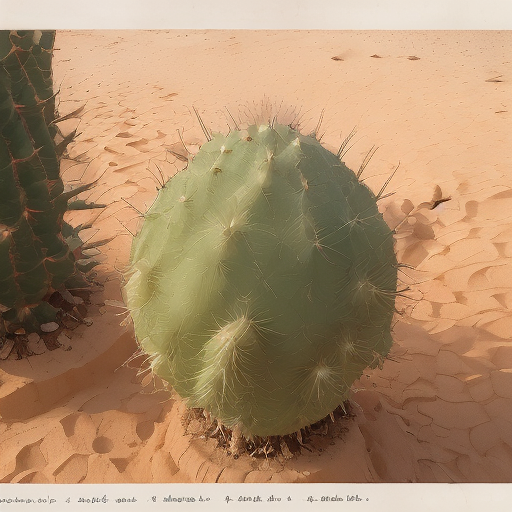

In [24]:
pipe(prompt="A small cactus with a happy face in the Sahara desert", generator=torch.Generator(device=pipe.device).manual_seed(0), height=512, width=512, num_inference_steps=4, guidance_scale=8.5).images[0]

In [26]:
sample_fn = LCMSamplingPipeline(
    pipe,
    prompt="A small cactus with a happy face in the Sahara desert",
    num_inference_steps=4,
    generator=torch.Generator(device=pipe.device).manual_seed(0),
    guidance_scale=8.5,
    height=512,
    width=512,
    add_noise=False
)

  0%|          | 0/4 [00:00<?, ?it/s]

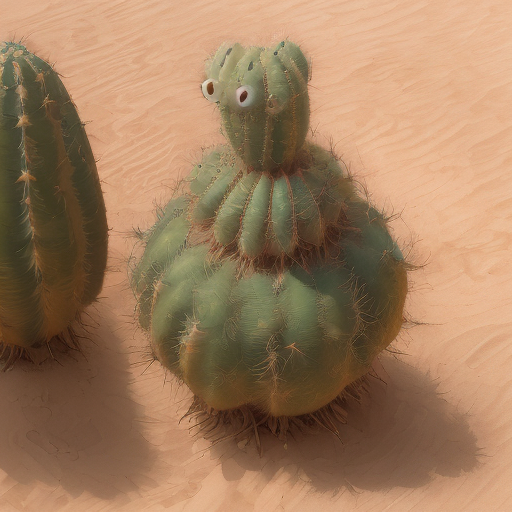

In [31]:
img = sample_fn()
numpy_to_pil(img)[0]
